---
title: "Looking at Kernel Matrices"
format:
  html:
    toc: true
    html-math-method: katex
    theme: lux
    fig-format: png
    freeze: true
execute:
  freeze: true
  cache: true
  enabled: false
---

# Kernel Matrix Vis

This notebook provides a few functions for visualizing the kernel matrix of dataset. The closer a kernel matrix looks to a gram kernel, the more visually seperable it is. In a way, it can be though of as a dimensionality reduction method but you're better off using Kernel PCA or a manifold learning method.

In [1]:
using Images,Plots,Statistics,Statistics, Base, StatsBase, ColorSchemes, ColorBlendModes,RDatasets
const cbm = ColorBlendModes
using LinearAlgebra

In [2]:
tX = rand(1000,10)
tY = tX[:, 1]
tX[sortperm(tY)];

In [3]:
theta(f :: Function) = @inline ((x1 :: Vector{Float64} , x2 :: Vector{Float64}) -> (dot(f(x1), f(x2))) :: Float64) :: Function

theta (generic function with 1 method)

In [4]:
import Base: *
function Base.:*(x :: Function, y :: Function)
    return (xs...) -> x(xs...) * y(xs...)
end
function Base.:+(x :: Function, y :: Function)
    return (xs...) -> x(xs...) + y(xs...)
end
function Base.:-(x :: Function, y :: Function)
    return (xs...) -> x(xs...) - y(xs...)
end
function Base.:/(x :: Function, y :: Function)
    return (xs...) -> x(xs...) / y(xs...)
end

# Generated Data

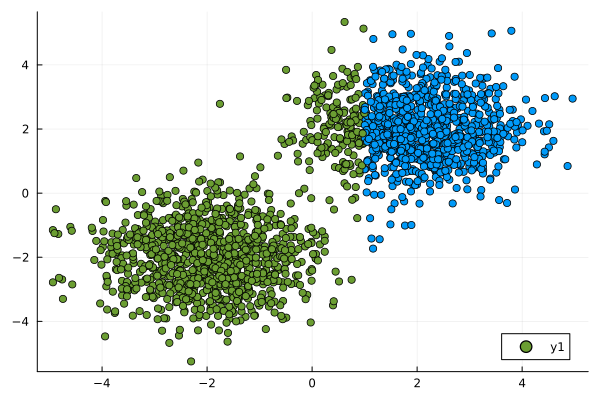

In [5]:
N = 100
N2 = 250
N3 = 167
X = [randn(1000, 2) .- 2; randn(1000, 2) .+ 2]
Y = (X[:, 1] .> 1) .|> Int64
scatter(X[:, 1], X[:, 2], color = Y)

In [6]:
# ╔═╡ 373b406a-d74a-4510-839b-1d2f14628dc6
@inline rbf(s::Union{Float64, Int64}, γ::Union{Float64, Int64})::Function = @inline (x1::Vector{Float64}, x2::Vector{Float64}) -> (s*ℯ^(-1*γ*norm(x1 - x2)^2))::Float64

# ╔═╡ 10fdf1eb-31eb-44e9-96ab-4da85629b3ba
@inline lin(v1::Union{Float64, Int64}, v2::Union{Float64, Int64}, c::Union{Float64, Int64})::Function = @inline (x1::Vector{Float64}, x2::Vector{Float64}) -> (v1 + v2*(x1 .- c)'*(x2 .- c))::Float64

# ╔═╡ 3aadd98a-a6b7-4358-94e4-2ad2b4791e15
@inline polynomial(s::Union{Float64, Int64}, c::Union{Float64, Int64}, d::Union{Float64, Int64})::Function = @inline (x1::Vector{Float64}, x2::Vector{Float64}) -> (s*(x1'x2 + c)^d)::Float64

# ╔═╡ 7ba30d43-0ca3-43fd-be7a-ef90d0a5b4d4
@inline rationalquadratic(s::Union{Float64, Int64}, α::Union{Float64, Int64}, γ::Union{Float64, Int64})::Function = @inline (x1::Vector{Float64}, x2::Vector{Float64}) -> (s*(1 + norm(x1 - x2)^2/(2*α*γ))^(-α))::Float64

# ╔═╡ 2f5adae1-9cc8-4d60-b7fd-468f139c5cc4
@inline sigmoid(s::Union{Float64, Int64}, α::Union{Float64, Int64}, c::Union{Float64, Int64})::Function = @inline (x1::Vector{Float64}, x2::Vector{Float64}) -> (s*tanh(α*x1'x2 + c))::Float64

# ╔═╡ c1710b7b-d655-46fd-845b-5dc0fb5c34e9
@inline notlinearspline(s::Union{Float64, Int64})::Function = @inline  (x1::Vector{Float64}, x2::Vector{Float64}) -> sum(s*(1 .+ x1 .* x2 + x1 .* x2 .* min.(x1, x2) .- (x1 .+ x2) ./ 2 .* min.(x1, x2) .^ 2 .+ 1/3 .* min.(x1, x2) .^ 3)) ::Float64

# ╔═╡ 45111bff-9f4d-4bdb-b228-75fa541b6e1f
@inline squashscale(x::Float64; max::Float64 = 1.0, min::Float64 = 1.0)::Float64 = (x - min)/(max - min)

# ╔═╡ 5306fdee-9d1a-46a7-ba34-5ec9ea6d70d3
@inline sigmoidscale(x::Float64)::Float64 = 1/(1 + ℯ^(-x))

# ╔═╡ 13a6fb9f-5285-485b-8fc9-1d852ce8c1c5
@inline sigmoidmedianscale(x::Float64; med::Float64 = 0.0)::Float64 = 1/(1 + ℯ^(-(x - med)))

# ╔═╡ 4b587bab-87ae-481d-85e6-e07b70ccd424
@inline sigmoidmeanscale(x::Float64; mean::Float64 = 0.0)::Float64 = 1/(1 + ℯ^(-(x - mean)))

sigmoidmeanscale (generic function with 1 method)

In [7]:


# ╔═╡ 4ff208f4-91c7-478d-9309-761a798423b2
function multiclasskernelplot(X::Matrix{Float64}, Y, kernel = rbf(1.0, 1.0), scale = squashscale; color = false, colorscheme = "viridis")
	D = size(X)[1]
	kM = zeros(D, D)
	cs = countmap(Y)
	csa = Dict(k => zeros(Int64, v) for (k, v) in cs)
	csi = Dict(k => 1 for (k, v) in cs)
	for (ind, y) in enumerate(Y)
		csa[y][csi[y]] = ind
		csi[y] += 1
	end
	iter = vcat(values(csa)...)
	@Threads.threads for i in (1:D |> collect)
		@simd for j in (1:D |> collect)
			@inbounds kM[i,j] = kernel(X[iter[i], :],  X[iter[j], :])
		end
	end
	kargs = Base.kwarg_decl.(methods(scale)) |> last
	avargs = Dict(:max => maximum, :min => minimum, :med => median, :mean => mean)
	sargs = Dict(k => v(kM) for (k, v) in avargs if k in kargs)
	scalem = @inline x -> scale(x; sargs...)
	@Threads.threads for i in (1:D |> collect)
		@simd for j in (1:D |> collect)
			@fastmath @inbounds kM[i,j] = scalem(kM[i, j])
		end
	end
	if color
		carr = zeros(RGBA{Float64}, D, D)
		uYs = length(unique(Y))
		colorsc = colorschemes[findcolorscheme(colorscheme)[1]]
		colordic = Dict(k => get(colorsc, 1/v) for (k,v) in zip(unique(Y), 1:uYs |> collect))
		@Threads.threads for i in (1:D |> collect)
			for j in (1:D |> collect)
				carr[i, j] = RGBA(cbm.blend(colordic[Y[iter[i]]], colordic[Y[iter[j]]], mode=BlendLighten), kM[i, j])
			end
		end
		return carr
	end
	kM .|> Gray
end

multiclasskernelplot (generic function with 3 methods)

# Multi class kernel vis no sorting


colorschemes containing "viridis"

  viridis             


 ...found 1 result for "viridis"


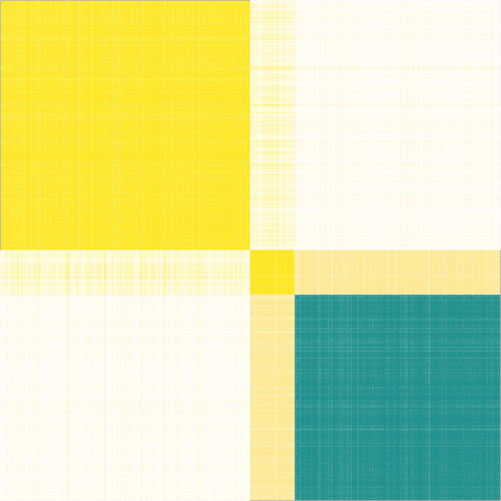

In [8]:
multiclasskernelplot(X, Y, rbf(10.0,1/10), sigmoidmedianscale, color = true)

In [10]:


# ╔═╡ dbc47d08-4e3b-42b2-b471-a869ca2f6224
function regressionkernelplot(X::Matrix{Float64}, Y::Vector{Float64}, kernel = rbf(1.0, 1.0), scale = squashscale; color = false, colorscheme = "viridis")
	iter = sortperm(Y)
	D = size(X)[1]
	kM = zeros(D, D)
	@Threads.threads for i in (1:D |> collect)
		@simd for j in (1:D |> collect)
			@inbounds kM[i,j] = kernel(X[iter[i], :],  X[iter[j], :])
		end
	end
	kargs = Base.kwarg_decl.(methods(scale)) |> last
	avargs = Dict(:max => maximum, :min => minimum, :med => median, :mean => mean)
	sargs = Dict(k => v(kM) for (k, v) in avargs if k in kargs)
	scalem = @inline x -> scale(x; sargs...)
	@Threads.threads for i in (1:D |> collect)
		@simd for j in (1:D |> collect)
			@fastmath @inbounds kM[i,j] = scalem(kM[i, j])
		end
	end
	kM .|> Gray
end

regressionkernelplot (generic function with 3 methods)

# Regression Plot

In [14]:
regressionkernelplot(tX, tY, theta(x -> [x[1] ^ 2; x; 1]), sigmoidmedianscale)

# multi class kernel plot sorted

In [8]:
function multiclasskernelplotsorted(X::Matrix{Float64}, Y, kernel = rbf(1.0, 1.0), scale = squashscale; color = false, colorscheme = "viridis")
	D = size(X)[1]
	kM = zeros(D, D)
	cs = countmap(Y)
	csa = Dict(k => zeros(Int64, v) for (k, v) in cs)
	csi = Dict(k => 1 for (k, v) in cs)
	for (ind, y) in enumerate(Y)
		csa[y][csi[y]] = ind
		csi[y] += 1
	end
	iter = vcat(values(csa)...)
	@Threads.threads for i in (1:D |> collect)
		@simd for j in (1:D |> collect)
			@inbounds kM[i,j] = kernel(X[iter[i], :],  X[iter[j], :])
		end
	end
	kargs = Base.kwarg_decl.(methods(scale)) |> last
	avargs = Dict(:max => maximum, :min => minimum, :med => median, :mean => mean)
	sargs = Dict(k => v(kM) for (k, v) in avargs if k in kargs)
	scalem = @inline x -> scale(x; sargs...)
	@Threads.threads for i in (1:D |> collect)
		@simd for j in (1:D |> collect)
			@fastmath @inbounds kM[i,j] = scalem(kM[i, j])
		end
	end
	if color
		carr = zeros(RGBA{Float64}, D, D)
		uYs = length(unique(Y))
		colorsc = colorschemes[findcolorscheme(colorscheme)[1]]
		colordic = Dict(k => get(colorsc, 1/v) for (k,v) in zip(unique(Y), 1:uYs |> collect))
		@Threads.threads for i in (1:D |> collect)
			for j in (1:D |> collect)
				carr[i, j] = RGBA(cbm.blend(colordic[Y[iter[i]]], colordic[Y[iter[j]]], mode=BlendLighten), kM[i, j])
			end
		end
		return carr
	end
	kM .|> Gray
end

multiclasskernelplotsorted (generic function with 3 methods)

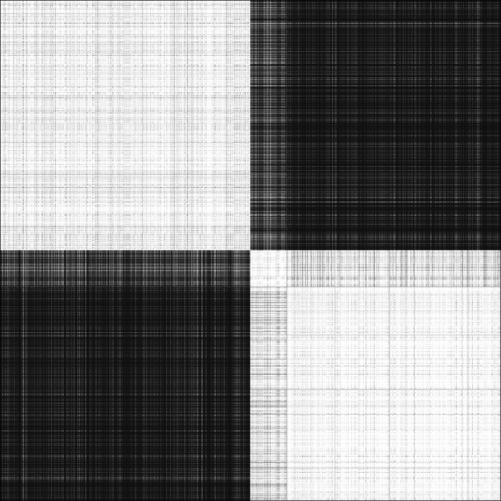

In [9]:
multiclasskernelplotsorted(X, Y, rbf(10.0,1/10), sigmoidmedianscale, color = false)